In [1]:
# use model as ViViT model or slowfast model
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.dataset import DatasetForVideo
from src.dataset import DatasetFor0D
from src.dataset import MultiModalDataset
from torch.utils.data import DataLoader

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
new_shot_df = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")
new_shot_df.head()

,shot,year,tftsrt,tipminf,tTQend,dt,frame_startup,frame_cutoff,frame_tTQend,frame_tipminf
0,19878,2018,1.15,4.198,4.180,0.018,21,891,887,890
1,19883,2018,1.15,5.710,5.684,0.026,21,1201,1195,1200
2,19919,2018,0.92,3.029,3.011,0.018,21,646,642,645
3,19920,2018,0.92,5.748,5.748,0.000,21,1239,1238,1238
4,19963,2018,0.92,3.143,3.122,0.021,21,670,665,669


In [3]:
ts_df = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_extend.csv")
print("# of shot : ", len(np.unique(ts_df.shot.values)))

# of shot :  969


# train
              precision    recall  f1-score   support

           0       0.92      0.98      0.94       122
           1       1.00      1.00      1.00     11801

    accuracy                           1.00     11923
   macro avg       0.96      0.99      0.97     11923
weighted avg       1.00      1.00      1.00     11923

# valid
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        31
           1       1.00      1.00      1.00      2510

    accuracy                           1.00      2541
   macro avg       0.91      0.95      0.93      2541
weighted avg       1.00      1.00      1.00      2541

# test
              precision    recall  f1-score   support

           0       0.95      0.92      0.94        39
           1       1.00      1.00      1.00      3290

    accuracy                           1.00      3329
   macro avg       0.97      0.96      0.97      3329
weighted avg       1.00      1.00      1.00      33

Text(33.0, 0.5, 'Actual')

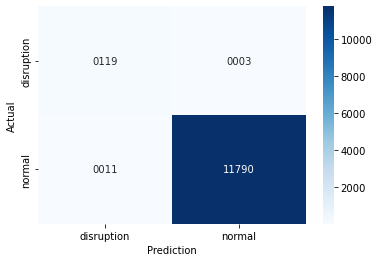

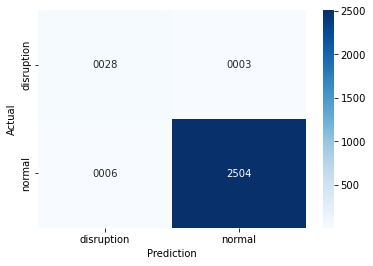

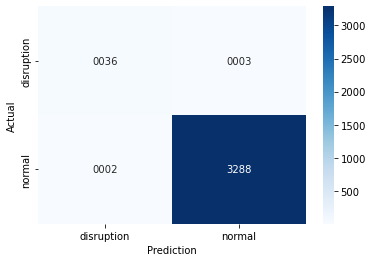

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# model evaluation for all dataset
df_total_score = pd.read_csv("./results/ViViT_clip_21_dist_3_total_score.csv")
df_total_score.shot = df_total_score.shot.astype(int)
df_total_score.head()

threshold = 0.9
df_total_score.pred = np.where(df_total_score.pred.values <= threshold, 1.0, 0.0)

# train
total_label = df_total_score[df_total_score.task == 'train'].label.values
total_pred = df_total_score[df_total_score.task == 'train'].pred.values
f1 = f1_score(total_label, total_pred, average = "macro")
auc = roc_auc_score(total_label, total_pred, average='macro')
conf_mat = confusion_matrix(total_label, total_pred)

print("# train")
print(classification_report(total_label, total_pred, labels = [0,1]))

plt.figure(1)
s = sns.heatmap(
    conf_mat, # conf_mat / np.sum(conf_mat),
    annot = True,
    fmt ='04d' ,# fmt = '.2f',
    cmap = 'Blues',
    xticklabels=["disruption","normal"],
    yticklabels=["disruption","normal"],
)

s.set_xlabel("Prediction")
s.set_ylabel("Actual")

# valid
total_label = df_total_score[df_total_score.task == 'valid'].label.values
total_pred = df_total_score[df_total_score.task == 'valid'].pred.values
f1 = f1_score(total_label, total_pred, average = "macro")
auc = roc_auc_score(total_label, total_pred, average='macro')
conf_mat = confusion_matrix(total_label, total_pred)

print("# valid")
print(classification_report(total_label, total_pred, labels = [0,1]))

plt.figure(2)
s = sns.heatmap(
    conf_mat, # conf_mat / np.sum(conf_mat),
    annot = True,
    fmt ='04d' ,# fmt = '.2f',
    cmap = 'Blues',
    xticklabels=["disruption","normal"],
    yticklabels=["disruption","normal"],
)

s.set_xlabel("Prediction")
s.set_ylabel("Actual")

# test
total_label = df_total_score[df_total_score.task == 'test'].label.values
total_pred = df_total_score[df_total_score.task == 'test'].pred.values
f1 = f1_score(total_label, total_pred, average = "macro")
auc = roc_auc_score(total_label, total_pred, average='macro')
conf_mat = confusion_matrix(total_label, total_pred)

print("# test")
print(classification_report(total_label, total_pred, labels = [0,1]))

plt.figure(3)
s = sns.heatmap(
    conf_mat, # conf_mat / np.sum(conf_mat),
    annot = True,
    fmt ='04d' ,# fmt = '.2f',
    cmap = 'Blues',
    xticklabels=["disruption","normal"],
    yticklabels=["disruption","normal"],
)

s.set_xlabel("Prediction")
s.set_ylabel("Actual")

In [5]:
# test data 가운데 예측에 실패한 shot : missing alarms
df_disrupt = df_total_score[(df_total_score.label == 0) & (df_total_score.task == 'test')]
df_disrupt[df_disrupt.pred == 1].shot

14605    21033
15556    20925
16451    21227
Name: shot, dtype: int64

In [6]:
# test data 가운데 예측에 실패한 shot : false alarms
df_disrupt = df_total_score[(df_total_score.label == 1) & (df_total_score.task == 'test')]
df_disrupt[df_disrupt.pred == 0].shot

14502    20612
14838    21036
Name: shot, dtype: int64

In [7]:
# valid data 가운데 예측에 실패한 shot
df_disrupt = df_total_score[(df_total_score.label == 0) & (df_total_score.task == 'valid')]
df_disrupt[df_disrupt.pred == 1].shot

13024    21159
14398    21131
14463    21615
Name: shot, dtype: int64

In [8]:
# train data 가운데 예측에 실패한 shot
df_disrupt = df_total_score[(df_total_score.label == 0) & (df_total_score.task == 'train')]
df_disrupt[df_disrupt.pred == 1].shot

1052    21198
7503    21660
9911    21387
Name: shot, dtype: int64

In [9]:
df_total_score = pd.read_csv("./results/Transformer_clip_21_dist_3_total_score.csv")
df_total_score[(df_total_score.label == 0) & (df_total_score.pred < 0.5)]

,task,label,shot,pred,tag
863,train,0.0,13491,0.000936,Transformer_clip_21_dist_3
864,train,0.0,13491,0.008572,Transformer_clip_21_dist_3
881,train,0.0,13492,0.156470,Transformer_clip_21_dist_3
882,train,0.0,13492,0.393622,Transformer_clip_21_dist_3
883,train,0.0,13492,0.242165,Transformer_clip_21_dist_3
...,...,...,...,...,...
45455,test,0.0,21615,0.015538,Transformer_clip_21_dist_3
45471,test,0.0,21661,0.254699,Transformer_clip_21_dist_3
45494,test,0.0,21663,0.490094,Transformer_clip_21_dist_3
45497,test,0.0,21663,0.189363,Transformer_clip_21_dist_3


In [10]:
df_total_score[(df_total_score.label == 0) & (df_total_score.pred > 0.5)]

,task,label,shot,pred,tag
21,train,0.0,13074,0.999515,Transformer_clip_21_dist_3
22,train,0.0,13074,0.998775,Transformer_clip_21_dist_3
23,train,0.0,13074,0.997632,Transformer_clip_21_dist_3
462,train,0.0,13413,0.995344,Transformer_clip_21_dist_3
463,train,0.0,13413,0.997641,Transformer_clip_21_dist_3
...,...,...,...,...,...
46095,test,0.0,21730,0.736637,Transformer_clip_21_dist_3
46096,test,0.0,21730,0.722097,Transformer_clip_21_dist_3
46150,test,0.0,21747,0.501580,Transformer_clip_21_dist_3
46151,test,0.0,21747,0.999618,Transformer_clip_21_dist_3


# train
              precision    recall  f1-score   support

           0       0.79      0.96      0.87      1881
           1       1.00      0.98      0.99     28126

    accuracy                           0.98     30007
   macro avg       0.90      0.97      0.93     30007
weighted avg       0.98      0.98      0.98     30007

# valid
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       488
           1       0.99      0.98      0.98      5915

    accuracy                           0.97      6403
   macro avg       0.88      0.92      0.90      6403
weighted avg       0.97      0.97      0.97      6403

# test
              precision    recall  f1-score   support

           0       0.61      0.87      0.72       595
           1       0.99      0.96      0.98      9194

    accuracy                           0.96      9789
   macro avg       0.80      0.92      0.85      9789
weighted avg       0.97      0.96      0.96      97

Text(33.0, 0.5, 'Actual')

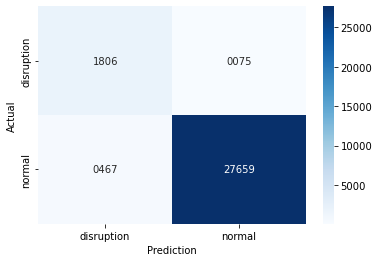

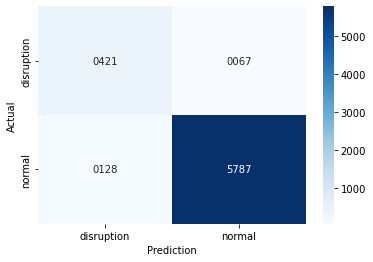

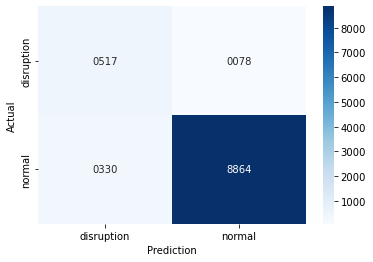

In [28]:
# model evaluation for all dataset
df_total_score = pd.read_csv("./results/Transformer_clip_21_dist_2_total_score.csv")
df_total_score.shot = df_total_score.shot.astype(int)

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

threshold = 0.9
df_total_score.pred = np.where(df_total_score.pred.values <= threshold, 1.0, 0.0)

# train
total_label = df_total_score[df_total_score.task == 'train'].label.values
total_pred = df_total_score[df_total_score.task == 'train'].pred.values
f1 = f1_score(total_label, total_pred, average = "macro")
auc = roc_auc_score(total_label, total_pred, average='macro')
conf_mat = confusion_matrix(total_label, total_pred)

print("# train")
print(classification_report(total_label, total_pred, labels = [0,1]))

plt.figure(1)
s = sns.heatmap(
    conf_mat, # conf_mat / np.sum(conf_mat),
    annot = True,
    fmt ='04d' ,# fmt = '.2f',
    cmap = 'Blues',
    xticklabels=["disruption","normal"],
    yticklabels=["disruption","normal"],
)

s.set_xlabel("Prediction")
s.set_ylabel("Actual")

# valid
total_label = df_total_score[df_total_score.task == 'valid'].label.values
total_pred = df_total_score[df_total_score.task == 'valid'].pred.values
f1 = f1_score(total_label, total_pred, average = "macro")
auc = roc_auc_score(total_label, total_pred, average='macro')
conf_mat = confusion_matrix(total_label, total_pred)

print("# valid")
print(classification_report(total_label, total_pred, labels = [0,1]))

plt.figure(2)
s = sns.heatmap(
    conf_mat, # conf_mat / np.sum(conf_mat),
    annot = True,
    fmt ='04d' ,# fmt = '.2f',
    cmap = 'Blues',
    xticklabels=["disruption","normal"],
    yticklabels=["disruption","normal"],
)

s.set_xlabel("Prediction")
s.set_ylabel("Actual")

# test
total_label = df_total_score[df_total_score.task == 'test'].label.values
total_pred = df_total_score[df_total_score.task == 'test'].pred.values
f1 = f1_score(total_label, total_pred, average = "macro")
auc = roc_auc_score(total_label, total_pred, average='macro')
conf_mat = confusion_matrix(total_label, total_pred)

print("# test")
print(classification_report(total_label, total_pred, labels = [0,1]))

plt.figure(3)
s = sns.heatmap(
    conf_mat, # conf_mat / np.sum(conf_mat),
    annot = True,
    fmt ='04d' ,# fmt = '.2f',
    cmap = 'Blues',
    xticklabels=["disruption","normal"],
    yticklabels=["disruption","normal"],
)

s.set_xlabel("Prediction")
s.set_ylabel("Actual")

# train
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1889
           1       0.98      1.00      0.99     27314

    accuracy                           0.98     29203
   macro avg       0.99      0.87      0.92     29203
weighted avg       0.98      0.98      0.98     29203

# valid
              precision    recall  f1-score   support

           0       0.97      0.72      0.83       481
           1       0.98      1.00      0.99      5656

    accuracy                           0.98      6137
   macro avg       0.98      0.86      0.91      6137
weighted avg       0.98      0.98      0.97      6137

# test
              precision    recall  f1-score   support

           0       0.89      0.75      0.81       596
           1       0.98      0.99      0.99      8681

    accuracy                           0.98      9277
   macro avg       0.93      0.87      0.90      9277
weighted avg       0.98      0.98      0.98      92

Text(33.0, 0.5, 'Actual')

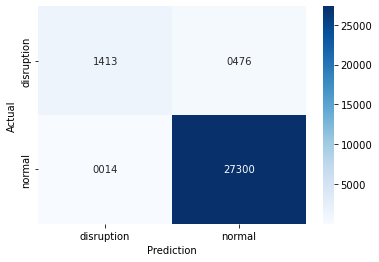

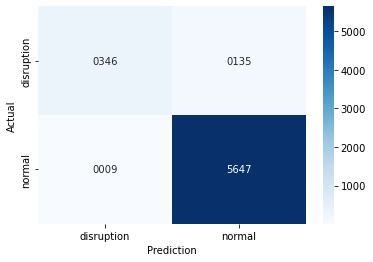

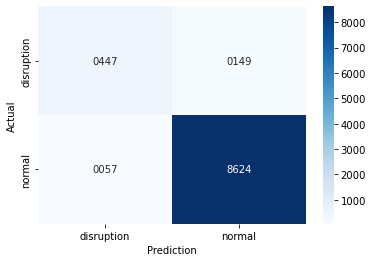

In [10]:
# model evaluation for all dataset
df_total_score = pd.read_csv("./results/Transformer_clip_21_dist_3_total_score.csv")
df_total_score.shot = df_total_score.shot.astype(int)

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.metrics import roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

threshold = 0.5
df_total_score.pred = np.where(df_total_score.pred.values <= threshold, 1.0, 0.0)

# train
total_label = df_total_score[df_total_score.task == 'train'].label.values
total_pred = df_total_score[df_total_score.task == 'train'].pred.values
f1 = f1_score(total_label, total_pred, average = "macro")
auc = roc_auc_score(total_label, total_pred, average='macro')
conf_mat = confusion_matrix(total_label, total_pred)

print("# train")
print(classification_report(total_label, total_pred, labels = [0,1]))

plt.figure(1)
s = sns.heatmap(
    conf_mat, # conf_mat / np.sum(conf_mat),
    annot = True,
    fmt ='04d' ,# fmt = '.2f',
    cmap = 'Blues',
    xticklabels=["disruption","normal"],
    yticklabels=["disruption","normal"],
)

s.set_xlabel("Prediction")
s.set_ylabel("Actual")

# valid
total_label = df_total_score[df_total_score.task == 'valid'].label.values
total_pred = df_total_score[df_total_score.task == 'valid'].pred.values
f1 = f1_score(total_label, total_pred, average = "macro")
auc = roc_auc_score(total_label, total_pred, average='macro')
conf_mat = confusion_matrix(total_label, total_pred)

print("# valid")
print(classification_report(total_label, total_pred, labels = [0,1]))

plt.figure(2)
s = sns.heatmap(
    conf_mat, # conf_mat / np.sum(conf_mat),
    annot = True,
    fmt ='04d' ,# fmt = '.2f',
    cmap = 'Blues',
    xticklabels=["disruption","normal"],
    yticklabels=["disruption","normal"],
)

s.set_xlabel("Prediction")
s.set_ylabel("Actual")

# test
total_label = df_total_score[df_total_score.task == 'test'].label.values
total_pred = df_total_score[df_total_score.task == 'test'].pred.values
f1 = f1_score(total_label, total_pred, average = "macro")
auc = roc_auc_score(total_label, total_pred, average='macro')
conf_mat = confusion_matrix(total_label, total_pred)

print("# test")
print(classification_report(total_label, total_pred, labels = [0,1]))

plt.figure(3)
s = sns.heatmap(
    conf_mat, # conf_mat / np.sum(conf_mat),
    annot = True,
    fmt ='04d' ,# fmt = '.2f',
    cmap = 'Blues',
    xticklabels=["disruption","normal"],
    yticklabels=["disruption","normal"],
)

s.set_xlabel("Prediction")
s.set_ylabel("Actual")

In [11]:
# test data 가운데 예측에 실패한 shot
df_disrupt = df_total_score[(df_total_score.label == 0) & (df_total_score.task == 'test')]
df_disrupt[(df_disrupt.pred == 1) & (df_disrupt.shot >= 20000)].shot

42698    20155
42716    20246
42750    20506
42777    20513
42792    20539
42817    20570
42853    20600
42854    20600
42933    20830
42974    20975
43035    21112
43060    21122
43146    21184
43164    21201
43190    21225
43236    21231
43265    21272
43283    21273
43299    21323
43376    21362
43426    21365
43427    21365
43454    21381
43492    21389
43593    21401
43689    21403
43716    21453
43882    21490
43917    21615
43933    21661
43958    21663
44532    21706
44557    21730
44614    21747
Name: shot, dtype: int64

In [12]:
# valid 가운데 예측에 실패한 shot
df_disrupt = df_total_score[(df_total_score.label == 0) & (df_total_score.task == 'valid')]
df_disrupt[(df_disrupt.pred == 1) & (df_disrupt.shot >= 20000)].shot

34109    20484
34168    20637
34185    20665
34211    20897
34236    20900
34255    20941
34312    20948
34362    20980
34402    21031
34428    21042
34479    21067
34503    21137
34623    21160
34641    21202
34691    21207
34752    21209
34819    21226
34854    21328
34882    21357
34944    21548
34994    21549
35063    21575
35092    21580
35093    21580
35133    21589
35153    21647
35172    21648
35205    21649
35251    21651
35311    21654
35337    21731
Name: shot, dtype: int64

In [13]:
# shot num 21310
# plot 0D data with time axis
import numpy as np
import pandas as pd
import os

save_dir = "./dataset/raw_videos/"

df_ts = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_extend.csv")
df_vis = pd.read_csv("./dataset/KSTAR_Disruption_Shot_List_extend.csv")

/tmp/ipykernel_1138157/2605800706.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


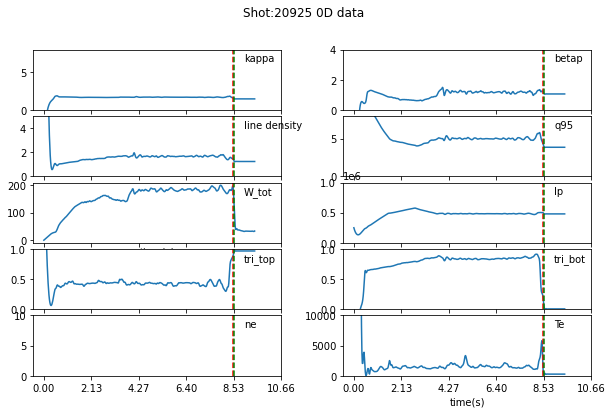

In [40]:
# see 20925 : Vision Transformer can not predict the disruption in this shot
shot_num = 20925
ts_data_0D = df_ts[df_ts['shot'] == shot_num]

# 0D data upload
t = ts_data_0D.time
ip = ts_data_0D['\\ipmhd'] * (-1)
kappa = ts_data_0D['\\kappa']
betap = ts_data_0D['\\betap']
betan = ts_data_0D['\\betan']
li = ts_data_0D['\\li']
Bc = ts_data_0D['\\bcentr']
q95 = ts_data_0D['\\q95']
tritop = ts_data_0D['\\tritop']
tribot = ts_data_0D['\\tribot']
W_tot = ts_data_0D['\\WTOT_DLM03']
ne = ts_data_0D['\\ne_inter01']
te = ts_data_0D['\\TS_CORE10:CORE10_TE']

# thermal quench and current quench time
t_TQend = df_vis[df_vis.shot==shot_num]['tTQend'].values[0]
t_ipminf = df_vis[df_vis.shot==shot_num]['tipminf'].values[0]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols = 2, nrows = 5, figsize = (10,6), gridspec_kw={"wspace":0.25, "hspace":0.1},sharex = True)
ax_vis = axes[4,1].get_gridspec()
axs = axes.ravel()

fig.suptitle("Shot:{} 0D data".format(shot_num))
axs[0].plot(t, kappa, label = "kappa")
axs[0].text(0.85, 0.8, "kappa", transform = axs[0].transAxes)
axs[1].plot(t, betap, label = 'betap')
axs[1].text(0.85, 0.8, "betap", transform = axs[1].transAxes)
axs[2].plot(t, li, label = 'line density')
axs[2].text(0.85, 0.8, "line density", transform = axs[2].transAxes)
axs[3].plot(t, q95, label = 'q95')
axs[3].text(0.85, 0.8, "q95", transform = axs[3].transAxes)
axs[4].plot(t, W_tot, label = 'W_tot')
axs[4].text(0.85, 0.8, "W_tot", transform = axs[4].transAxes)
axs[5].plot(t, ip, label = 'Ip')
axs[5].text(0.85, 0.8, "Ip", transform = axs[5].transAxes)
axs[6].plot(t, tritop, label = 'tri_top')
axs[6].text(0.85, 0.8, "tri_top", transform = axs[6].transAxes)
axs[7].plot(t, tribot, label = 'tri_bot')
axs[7].text(0.85, 0.8, "tri_bot", transform = axs[7].transAxes)
axs[8].plot(t, ne, label = 'ne')
axs[8].text(0.85, 0.8, "ne", transform = axs[8].transAxes)
axs[9].plot(t, te, label = 'Te')
axs[9].text(0.85, 0.8, "Te", transform = axs[9].transAxes)

for idx in range(0,10):
    axs[idx].axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", )
    axs[idx].axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed")

    if idx in [4,9]:
        quantile = [0, 0.25, 0.5, 0.75, 1.0, 1.25]
        t_quantile = [q * t_ipminf for q in quantile]
        axs[idx].set_xlabel("time(s)")
        axs[idx].set_xticks(t_quantile)
        axs[idx].set_xticklabels(["{:.2f}".format(t) for t in t_quantile])
        
axs[0].set_ylim([0, 8])
axs[1].set_ylim([0, 4])
axs[2].set_ylim([0, 5])
axs[3].set_ylim([0, 8])
axs[5].set_ylim([0, 1e6])
axs[6].set_ylim([0, 1])
axs[7].set_ylim([0, 1])
axs[8].set_ylim([0, 10])
axs[9].set_ylim([0, 1e4])

fig.tight_layout()

/tmp/ipykernel_1138157/1771084216.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


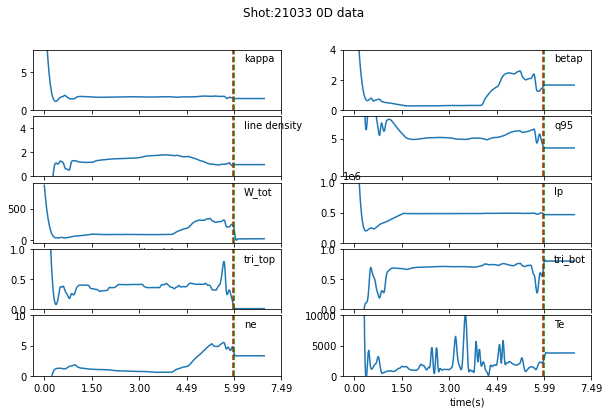

In [39]:
# see 21033 : Vision Transformer can not predict the disruption in this shot
shot_num = 21033
ts_data_0D = df_ts[df_ts['shot'] == shot_num]

# 0D data upload
t = ts_data_0D.time
ip = ts_data_0D['\\ipmhd'] * (-1)
kappa = ts_data_0D['\\kappa']
betap = ts_data_0D['\\betap']
betan = ts_data_0D['\\betan']
li = ts_data_0D['\\li']
Bc = ts_data_0D['\\bcentr']
q95 = ts_data_0D['\\q95']
tritop = ts_data_0D['\\tritop']
tribot = ts_data_0D['\\tribot']
W_tot = ts_data_0D['\\WTOT_DLM03']
ne = ts_data_0D['\\ne_inter01']
te = ts_data_0D['\\TS_CORE10:CORE10_TE']

# thermal quench and current quench time
t_TQend = df_vis[df_vis.shot==shot_num]['tTQend'].values[0]
t_ipminf = df_vis[df_vis.shot==shot_num]['tipminf'].values[0]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols = 2, nrows = 5, figsize = (10,6), gridspec_kw={"wspace":0.25, "hspace":0.1},sharex = True)
ax_vis = axes[4,1].get_gridspec()
axs = axes.ravel()

fig.suptitle("Shot:{} 0D data".format(shot_num))
axs[0].plot(t, kappa, label = "kappa")
axs[0].text(0.85, 0.8, "kappa", transform = axs[0].transAxes)
axs[1].plot(t, betap, label = 'betap')
axs[1].text(0.85, 0.8, "betap", transform = axs[1].transAxes)
axs[2].plot(t, li, label = 'line density')
axs[2].text(0.85, 0.8, "line density", transform = axs[2].transAxes)
axs[3].plot(t, q95, label = 'q95')
axs[3].text(0.85, 0.8, "q95", transform = axs[3].transAxes)
axs[4].plot(t, W_tot, label = 'W_tot')
axs[4].text(0.85, 0.8, "W_tot", transform = axs[4].transAxes)
axs[5].plot(t, ip, label = 'Ip')
axs[5].text(0.85, 0.8, "Ip", transform = axs[5].transAxes)
axs[6].plot(t, tritop, label = 'tri_top')
axs[6].text(0.85, 0.8, "tri_top", transform = axs[6].transAxes)
axs[7].plot(t, tribot, label = 'tri_bot')
axs[7].text(0.85, 0.8, "tri_bot", transform = axs[7].transAxes)
axs[8].plot(t, ne, label = 'ne')
axs[8].text(0.85, 0.8, "ne", transform = axs[8].transAxes)
axs[9].plot(t, te, label = 'Te')
axs[9].text(0.85, 0.8, "Te", transform = axs[9].transAxes)

for idx in range(0,10):
    axs[idx].axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", )
    axs[idx].axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed")

    if idx in [4,9]:
        quantile = [0, 0.25, 0.5, 0.75, 1.0, 1.25]
        t_quantile = [q * t_ipminf for q in quantile]
        axs[idx].set_xlabel("time(s)")
        axs[idx].set_xticks(t_quantile)
        axs[idx].set_xticklabels(["{:.2f}".format(t) for t in t_quantile])
        
axs[0].set_ylim([0, 8])
axs[1].set_ylim([0, 4])
axs[2].set_ylim([0, 5])
axs[3].set_ylim([0, 8])
axs[5].set_ylim([0, 1e6])
axs[6].set_ylim([0, 1])
axs[7].set_ylim([0, 1])
axs[8].set_ylim([0, 10])
axs[9].set_ylim([0, 1e4])

fig.tight_layout()

100%|██████████| 2272/2272 [02:07<00:00, 17.80it/s]


time :  2293
prob :  2293
thermal quench :  10.038
current quench:  10.056


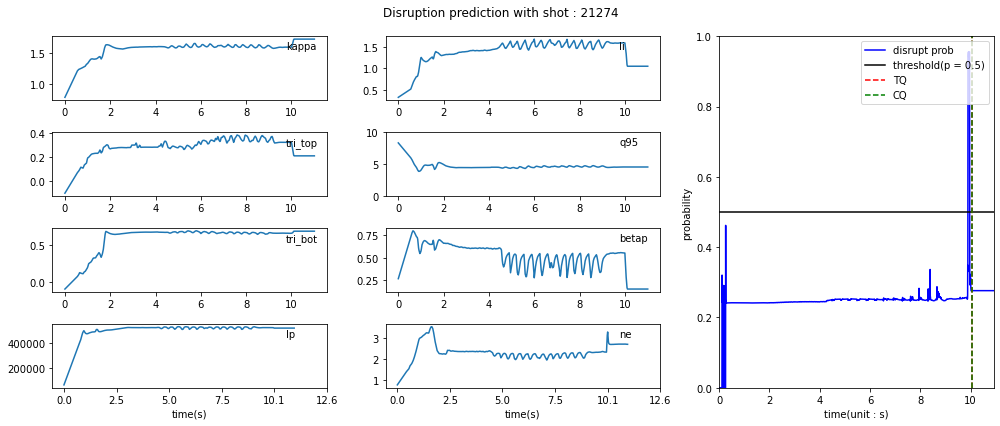

In [4]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 128,
    patch_size = 16,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:" + str(3)
else:
    device = 'cpu'

model.to(device)

model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_0_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor

shot_num = 21274

time_x, prob_list = generate_prob_curve(
    file_path = "./dataset/test-shot",
    model = model, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png",
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    ts_data_dir = "./dataset/KSTAR_Disruption_ts_data_extend.csv",
    shot_num = shot_num,
    clip_len = 21,
    dist_frame = 0,
)

100%|██████████| 2273/2273 [02:05<00:00, 18.10it/s]


time :  2293
prob :  2293
thermal quench :  10.038
current quench:  10.056


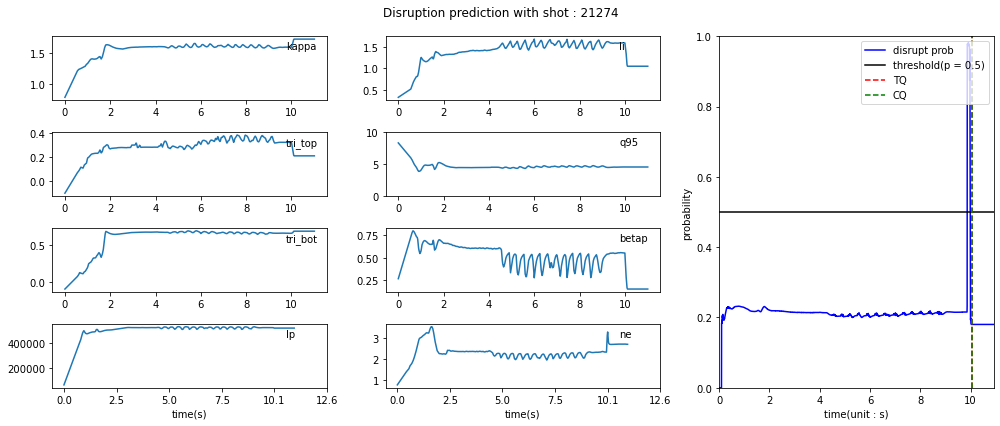

In [9]:
from src.models.slowfast import SlowFast
from src.models.resnet import Bottleneck3D

model = SlowFast(
        input_shape = (3, 20, 224, 224),
        block = Bottleneck3D,
        layers = [1,2,2,1],
        alpha = 4,
        tau_fast = 1,
        mlp_hidden = 64,
        num_classes = 2,
        device = device
)

model.to(device)
model.load_state_dict(torch.load("./weights/slowfast_clip_21_dist_0_best.pt"))

shot_num = 21274

time_x, prob_list = generate_prob_curve(
    file_path = "./dataset/test-shot",
    model = model, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png",
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    ts_data_dir = "./dataset/KSTAR_Disruption_ts_data_extend.csv",
    shot_num = shot_num,
    clip_len = 20,
    dist_frame = 0,
)

100%|██████████| 2272/2272 [02:21<00:00, 16.09it/s]


time :  2293
prob :  2293
thermal quench :  10.038
current quench:  10.056


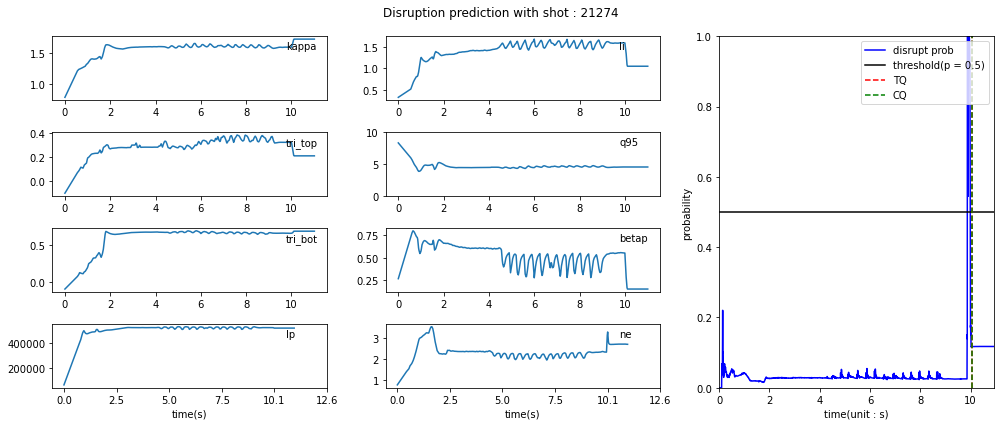

In [10]:
from src.models.R2Plus1D import  R2Plus1DClassifier

model = R2Plus1DClassifier(
        input_size  = (3, 21, 128, 128),
        num_classes = 2, 
        layer_sizes = [1,2,2,1], 
        pretrained = False, 
        alpha = 0.01
    )

model.to(device)
model.load_state_dict(torch.load("./weights/R2Plus1D_clip_21_dist_0_best.pt"))

shot_num = 21274

time_x, prob_list = generate_prob_curve(
    file_path = "./dataset/test-shot",
    model = model, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png",
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    ts_data_dir = "./dataset/KSTAR_Disruption_ts_data_extend.csv",
    shot_num = shot_num,
    clip_len = 21,
    dist_frame = 0,
)

,model,F1-score,AUC,Accuracy,Precision,Recall,Prediction-time
0,R2Plus1D,0.928,0.949,0.99,0.82,0.90,4.760ms
1,R2Plus1D,0.922,0.949,0.99,0.80,0.90,9.520ms
2,R2Plus1D,0.926,0.935,0.99,0.84,0.87,14.280ms
3,R2Plus1D,0.889,0.879,0.99,0.81,0.76,19.040ms
4,R2Plus1D,0.828,0.780,0.99,0.80,0.56,23.800ms
5,SlowFast,0.940,0.949,1.00,0.86,0.90,4.760ms
6,SlowFast,0.947,0.950,1.00,0.89,0.90,9.520ms
7,SlowFast,0.925,0.928,0.99,0.85,0.86,14.280ms
8,SlowFast,0.849,0.822,0.99,0.77,0.65,19.040ms
9,SlowFast,0.808,0.708,0.99,0.66,0.56,23.800ms


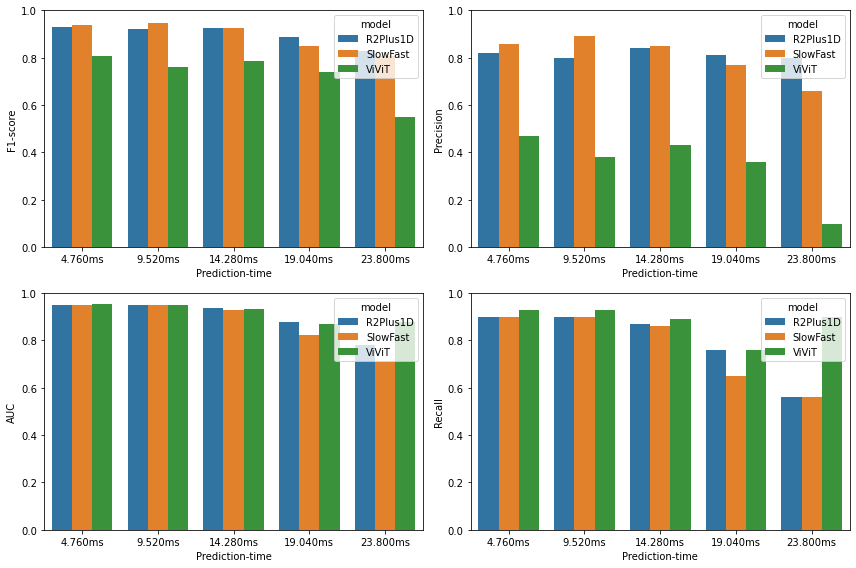

In [20]:
# Graph for publishing paper : Model comparison for video data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model_list = ['R2Plus1D']*5+['SlowFast']*5+['ViViT']*5
dist_list = ["{:.3f}ms".format(4.76 * i) for i in [1,2,3,4,5]] * 3 
f1_list = [0.928, 0.922, 0.926, 0.889, 0.828] + [0.94, 0.947, 0.925, 0.849, 0.808] + [0.809,0.760,0.786,0.739,0.55]
auc_list = [0.949, 0.949,0.935, 0.879, 0.780] + [0.949, 0.95, 0.928, 0.822, 0.708] + [0.955,0.95,0.933,0.868,0.876]
acc_list = [0.99, 0.99, 0.99, 0.99, 0.99] + [1.0, 1.0, 0.99, 0.99, 0.99] + [0.98,0.97,0.98,0.97,0.85]
dis_pre_list = [0.82,0.80,0.84, 0.81, 0.80] + [0.86, 0.89, 0.85, 0.77, 0.66] + [0.47,0.38,0.43,0.36,0.10]
dis_rec_list = [0.90, 0.90,0.87, 0.76, 0.56] + [0.90, 0.90, 0.86, 0.65, 0.56] + [0.93,0.93,0.89,0.76,0.90]

df_exp_algorithm = pd.DataFrame({
    "model":model_list,
    "F1-score":f1_list,
    "AUC":auc_list,
    "Accuracy":acc_list,
    "Precision":dis_pre_list,
    "Recall":dis_rec_list,
    "Prediction-time":dist_list
})

fig, axes = plt.subplots(2,2, sharex = False, figsize = (12, 8))
sns.barplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'F1-score', hue = 'model', ax = axes[0,0])
sns.barplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'AUC', hue = 'model', ax = axes[1,0])
sns.barplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'Precision', hue = 'model', ax = axes[0,1])
sns.barplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'Recall', hue = 'model', ax = axes[1,1])

axes[0,0].set_ylim([0,1.0])
axes[1,0].set_ylim([0,1.0])
axes[0,1].set_ylim([0,1.0])
axes[1,1].set_ylim([0,1.0])
fig.tight_layout()

df_exp_algorithm.groupby(by="model").apply(lambda x : x[:])

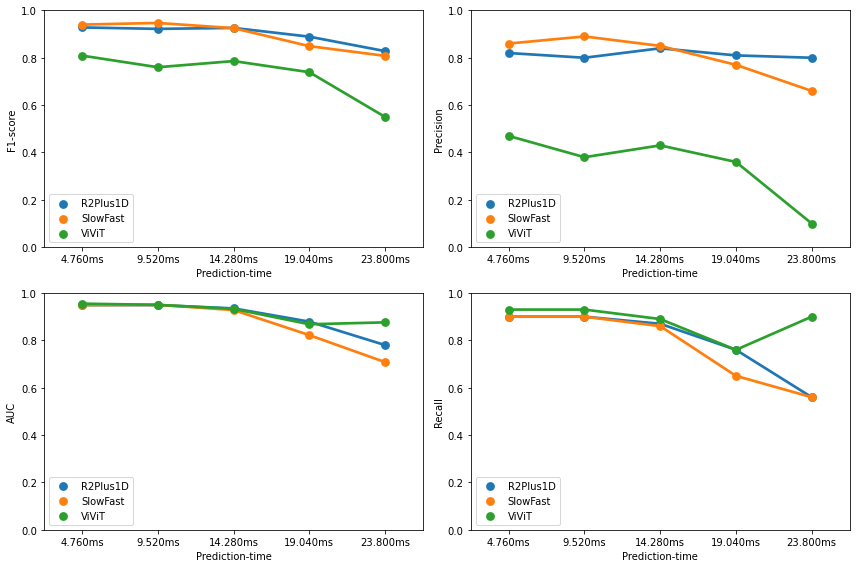

In [21]:
fig, axes = plt.subplots(2,2, sharex = False, figsize = (12, 8))
sns.pointplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'F1-score', hue = 'model', ax = axes[0,0])
axes[0,0].legend(loc='lower left')
sns.pointplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'AUC', hue = 'model', ax = axes[1,0])
axes[1,0].legend(loc='lower left')
sns.pointplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'Precision', hue = 'model', ax = axes[0,1], )
axes[0,1].legend(loc='lower left')
sns.pointplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'Recall', hue = 'model', ax = axes[1,1])
axes[1,1].legend(loc='lower left')

axes[0,0].set_ylim([0,1.0])
axes[1,0].set_ylim([0,1.0])
axes[0,1].set_ylim([0,1.0])
axes[1,1].set_ylim([0,1.0])
fig.tight_layout()

,model,F1-score,AUC,Accuracy,Precision,Recall,Prediction-time
0,Transformer,0.906,0.899,0.97,0.84,0.81,19.040ms
1,Transformer,0.886,0.880,0.97,0.80,0.78,38.080ms
2,Transformer,0.891,0.882,0.97,0.82,0.78,57.120ms
3,Transformer,0.882,0.882,0.97,0.78,0.78,76.160ms
4,Transformer,0.874,0.881,0.96,0.75,0.78,95.200ms
5,CnnLSTM,0.865,0.823,0.97,0.87,0.65,19.040ms
6,CnnLSTM,0.858,0.860,0.96,0.73,0.74,38.080ms
7,CnnLSTM,0.848,0.880,0.95,0.66,0.80,57.120ms
8,CnnLSTM,0.831,0.878,0.94,0.61,0.80,76.160ms
9,CnnLSTM,0.837,0.868,0.95,0.64,0.77,95.200ms


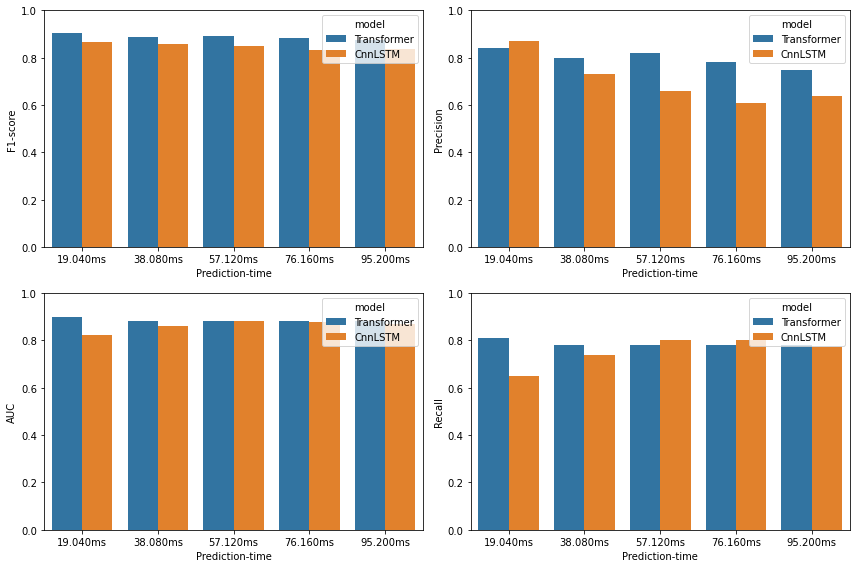

In [6]:
# Graph for publishing paper : Model comparison for 0D data
model_list = ['Transformer']*5+['CnnLSTM']*5
dist_list = ["{:.3f}ms".format(4.76 * 4 * i) for i in [1,2,3,4,5]] * 2
f1_list = [0.906,0.886,0.891,0.882,0.874] + [0.865,0.858,0.848,0.831,0.837] 
auc_list = [0.899,0.880,0.882,0.882,0.881] + [0.823,0.860,0.880,0.878,0.868]
acc_list = [0.97,0.97,0.97,0.97,0.96] + [0.97,0.96,0.95,0.94,0.95]
dis_pre_list = [0.84,0.80,0.82,0.78,0.75] + [0.87,0.73,0.66,0.61,0.64]
dis_rec_list = [0.81,0.78,0.78,0.78,0.78] + [0.65,0.74,0.80,0.80,0.77]

df_exp_algorithm = pd.DataFrame({
    "model":model_list,
    "F1-score":f1_list,
    "AUC":auc_list,
    "Accuracy":acc_list,
    "Precision":dis_pre_list,
    "Recall":dis_rec_list,
    "Prediction-time":dist_list
})

fig, axes = plt.subplots(2,2, sharex = False, figsize = (12, 8))
sns.barplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'F1-score', hue = 'model', ax = axes[0,0])
sns.barplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'AUC', hue = 'model', ax = axes[1,0])
sns.barplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'Precision', hue = 'model', ax = axes[0,1])
sns.barplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'Recall', hue = 'model', ax = axes[1,1])

axes[0,0].set_ylim([0,1.0])
axes[1,0].set_ylim([0,1.0])
axes[0,1].set_ylim([0,1.0])
axes[1,1].set_ylim([0,1.0])
fig.tight_layout()

df_exp_algorithm.groupby(by="model").apply(lambda x : x[:])

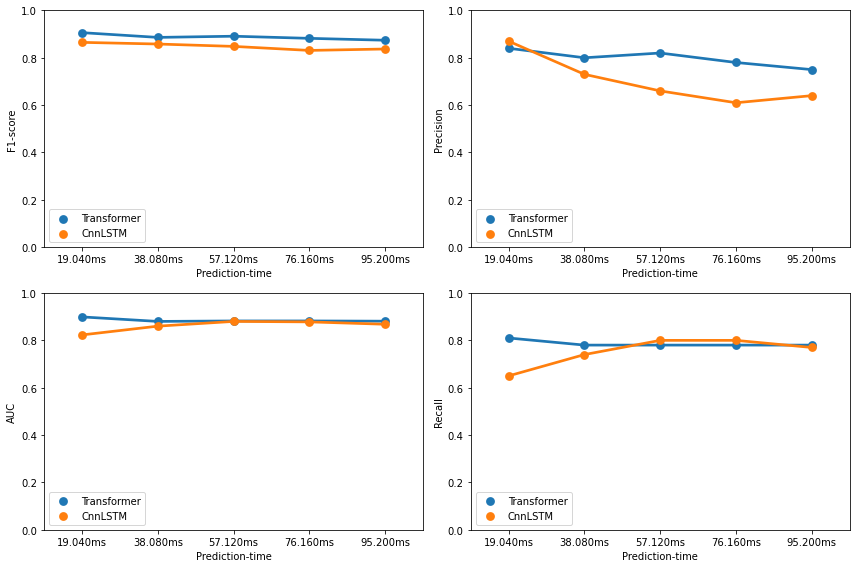

In [18]:
fig, axes = plt.subplots(2,2, sharex = False, figsize = (12, 8))
sns.pointplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'F1-score', hue = 'model', ax = axes[0,0])
axes[0,0].legend(loc='lower left')
sns.pointplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'AUC', hue = 'model', ax = axes[1,0])
axes[1,0].legend(loc='lower left')
sns.pointplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'Precision', hue = 'model', ax = axes[0,1], )
axes[0,1].legend(loc='lower left')
sns.pointplot(data = df_exp_algorithm, x = 'Prediction-time', y = 'Recall', hue = 'model', ax = axes[1,1])
axes[1,1].legend(loc='lower left')

axes[0,0].set_ylim([0,1.0])
axes[1,0].set_ylim([0,1.0])
axes[0,1].set_ylim([0,1.0])
axes[1,1].set_ylim([0,1.0])
fig.tight_layout()

<AxesSubplot:xlabel='Loss', ylabel='F1_score'>

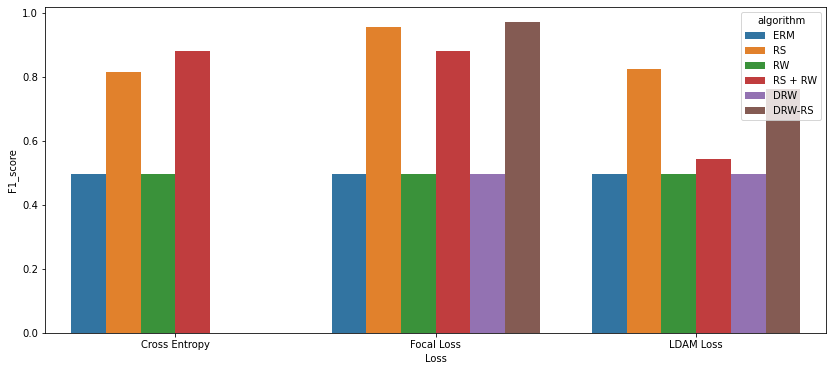

In [13]:
# plot as a bar graph
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

algorithm_list = ['ERM', 'RS', 'RW', 'RS + RW'] + ['ERM', 'RS', 'RW', 'RS + RW', 'DRW', 'DRW-RS'] + ['ERM', 'RS', 'RW', 'RS + RW', 'DRW', 'DRW-RS']
loss_list = ['Cross Entropy'] * 4 + ['Focal Loss'] * 6 + ['LDAM Loss'] * 6
f1_list = [0.496, 0.813, 0.496, 0.880] + [0.496, 0.956, 0.496, 0.88, 0.496, 0.97] + [0.496, 0.824, 0.496, 0.543, 0.496, 0.76]

df_exp_algorithm = pd.DataFrame({
    "Loss" : loss_list,
    "F1_score" : f1_list,
    "algorithm" : algorithm_list
})

plt.figure(figsize = (14,6))
sns.barplot(data = df_exp_algorithm, x = 'Loss', y = 'F1_score', hue = 'algorithm')

Experiment Result for different algorithm for 1D CNN - LSTM - 0D data

<AxesSubplot:xlabel='Loss', ylabel='F1_score'>

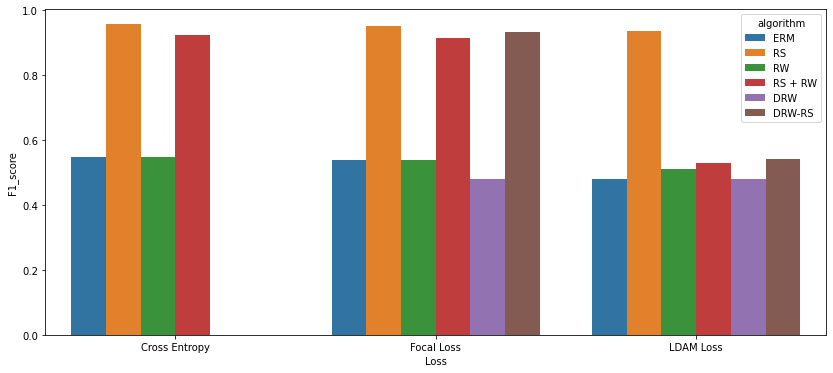

In [28]:
# Conv LSTM model
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

algorithm_list = ['ERM', 'RS', 'RW', 'RS + RW'] + ['ERM', 'RS', 'RW', 'RS + RW', 'DRW', 'DRW-RS'] + ['ERM', 'RS', 'RW', 'RS + RW', 'DRW', 'DRW-RS']
loss_list = ['Cross Entropy'] * 4 + ['Focal Loss'] * 6 + ['LDAM Loss'] * 6
f1_list = [0.548, 0.957, 0.548, 0.924] + [0.538, 0.952, 0.538, 0.913, 0.479, 0.934] + [0.479, 0.935, 0.51, 0.529, 0.479, 0.543]

df_exp_algorithm = pd.DataFrame({
    "Loss" : loss_list,
    "F1_score" : f1_list,
    "algorithm" : algorithm_list
})

plt.figure(figsize = (14,6))
sns.barplot(data = df_exp_algorithm, x = 'Loss', y = 'F1_score', hue = 'algorithm')

Image sequence vs 0D data vs Probability Curve Plot

In [6]:
shot_num = 21310
df_0D = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_extend.csv")

In [7]:
ts_data_0D = df_0D[df_0D.shot == shot_num]
ts_data_0D.head()

,time,shot,\q95,\ipmhd,\kappa,\tritop,\tribot,\betap,\betan,\li,\bcentr,\nb11_pnb,\nb12_pnb,\nb13_pnb,\ne_inter01,\ne_tci01,\ne_tci02,\RC03,\VCM03,\WTOT_DLM03,\TS_CORE1:CORE1_TE,\TS_CORE2:CORE2_TE,\TS_CORE3:CORE3_TE,\TS_CORE4:CORE4_TE,\TS_CORE5:CORE5_TE,\TS_CORE6:CORE6_TE,\TS_CORE7:CORE7_TE,\TS_CORE8:CORE8_TE,\TS_CORE9:CORE9_TE,\TS_CORE10:CORE10_TE,\TS_CORE11:CORE11_TE,\TS_CORE12:CORE12_TE,\TS_CORE13:CORE13_TE,\TS_CORE14:CORE14_TE,\TS_EDGE1:EDGE1_TE,\TS_EDGE2:EDGE2_TE,\TS_EDGE3:EDGE3_TE,\TS_EDGE4:EDGE4_TE,\TS_EDGE5:EDGE5_TE,\TS_EDGE6:EDGE6_TE,\TS_EDGE7:EDGE7_TE,\TS_EDGE8:EDGE8_TE,\TS_EDGE9:EDGE9_TE,\TS_EDGE10:EDGE10_TE,\TS_EDGE11:EDGE11_TE,\TS_EDGE12:EDGE12_TE,\TS_EDGE13:EDGE13_TE,\TS_EDGE14:EDGE14_TE,\TS_EDGE15:EDGE15_TE,\TS_CORE1:CORE1_NE,\TS_CORE2:CORE2_NE,\TS_CORE3:CORE3_NE,\TS_CORE4:CORE4_NE,\TS_CORE5:CORE5_NE,\TS_CORE6:CORE6_NE,\TS_CORE7:CORE7_NE,\TS_CORE8:CORE8_NE,\TS_CORE9:CORE9_NE,\TS_CORE10:CORE10_NE,\TS_CORE11:CORE11_NE,\TS_CORE12:CORE12_NE,\TS_CORE13:CORE13_NE,\TS_CORE14:CORE14_NE,\TS_EDGE1:EDGE1_NE,\TS_EDGE2:EDGE2_NE,\TS_EDGE3:EDGE3_NE,\TS_EDGE4:EDGE4_NE,\TS_EDGE5:EDGE5_NE,\TS_EDGE6:EDGE6_NE,\TS_EDGE7:EDGE7_NE,\TS_EDGE8:EDGE8_NE,\TS_EDGE9:EDGE9_NE,\TS_EDGE10:EDGE10_NE,\TS_EDGE11:EDGE11_NE,\TS_EDGE12:EDGE12_NE,\TS_EDGE13:EDGE13_NE,\TS_EDGE14:EDGE14_NE,\TS_EDGE15:EDGE15_NE,frame_idx
919,0.000000,21310,1061.016362,-108528.127480,0.855080,-0.048230,-0.048230,0.586226,0.408722,0.162515,-1.866473,NaN,NaN,NaN,-0.654833,0.318397,NaN,-101142.036125,-74296.960451,-29.765970,-56525.093174,144.800000,-1783.601534,-1942.904368,18978.494012,6268.703677,28779.480352,64969.193478,307.798152,-868.498634,3433.883814,-1572.497206,11618.542560,584.103287,NaN,-10604.811349,-2403.196682,3024.900192,909.203213,1516.401528,18918.522819,870.299492,20691.289852,-167.400687,48926.323824,0.0,0.0,NaN,NaN,-1.366323e+18,3.994855e+17,1.248520e+18,-8.454726e+17,8.284847e+18,-2.979797e+18,5.305456e+18,-2.126418e+18,1.642516e+18,3.273757e+18,7.827597e+17,4.232639e+18,-5.801088e+18,-1.759138e+19,NaN,-1.766276e+18,-8.178242e+16,2.586179e+18,4.265692e+18,-9.036449e+18,1.226222e+18,4.373478e+18,4.647083e+16,7.580386e+19,2.554893e+18,0.0,0.0,NaN,NaN,0
920,0.019048,21310,1029.587857,-115714.113862,0.866813,-0.044081,-0.044081,0.583825,0.414322,0.173383,-1.866473,NaN,NaN,NaN,-0.553027,0.330462,NaN,-108838.177147,-85844.183889,-26.800731,-53437.626822,142.552381,-1673.468114,-1815.018424,18326.837173,6048.132068,27441.347975,61977.727115,306.731583,-733.489179,3309.084643,-1458.402112,11167.340472,613.360255,NaN,-9943.591734,-2252.873034,2930.576368,889.012579,1485.734799,18084.655040,834.604278,19741.271338,-152.505415,46657.713130,0.0,0.0,NaN,NaN,-1.028521e+18,5.093027e+17,1.268146e+18,-7.729360e+17,7.920634e+18,-2.744805e+18,5.078331e+18,-1.963996e+18,1.621359e+18,3.166066e+18,7.586622e+17,4.048234e+18,-5.436816e+18,-1.660220e+19,NaN,-1.657096e+18,5.307255e+16,2.484469e+18,4.089025e+18,-8.526622e+18,1.230963e+18,4.206163e+18,5.488603e+16,7.247240e+19,2.482517e+18,0.0,0.0,NaN,NaN,4
921,0.038095,21310,998.159351,-122900.100244,0.878547,-0.039933,-0.039933,0.581425,0.419922,0.184251,-1.866473,NaN,NaN,NaN,-0.451221,0.342527,NaN,-116534.318169,-97391.407326,-23.835492,-50350.160471,140.304762,-1563.334694,-1687.132480,17675.180334,5827.560460,26103.215598,58986.260753,305.665014,-598.479725,3184.285473,-1344.307017,10716.138385,642.617224,NaN,-9282.372119,-2102.549386,2836.252544,868.821945,1455.068070,17250.787261,798.909064,18791.252824,-137.610143,44389.102436,0.0,0.0,NaN,NaN,-6.907187e+17,6.191199e+17,1.287771e+18,-7.003994e+17,7.556421e+18,-2.509812e+18,4.851205e+18,-1.801575e+18,1.600202e+18,3.058375e+18,7.345647e+17,3.863828e+18,-5.072545e+18,-1.561302e+19,NaN,-1.547916e+18,1.879275e+17,2.382759e+18,3.912359e+18,-8.016796e+18,1.235705e+18,4.038848e+18,6.330122e+16,6.914094e+19,2.410140e+18,0.0,0.0,NaN,NaN,8
922,0.057143,21310,966.730845,-130086.086626,0.890280,-0.035785,-0.035785,0.579024,0.425522,0.195120,-1.866472,NaN,NaN,NaN,-0.349415,0.354591,NaN,

In [10]:
t_TQend = new_shot_df[new_shot_df.shot==shot_num]['tTQend'].values[0]
t_ipminf = new_shot_df[new_shot_df.shot==shot_num]['tipminf'].values[0]

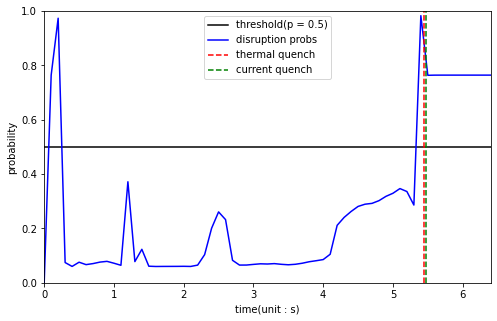

In [11]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:" + str(3)
else:
    device = 'cpu'

model.to(device)
model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_0_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor
video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)
time_x, prob_list = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 32, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 0,
    use_continuous_frame = False
)

In [12]:
from src.models.ViViT import ViViT
import os

model = ViViT(
    image_size = 128,
    patch_size = 32,
    n_classes = 2,
    n_frames = 21,
    dim = 64,
    depth = 4,
    n_heads = 8,
    pool = "cls",
    in_channels = 3,
    d_head = 64,
    dropout = 0.25,
    embedd_dropout=0.25,
    scale_dim = 4
)

# torch cuda initialize and clear cache
torch.cuda.init()
torch.cuda.empty_cache()

# device allocation
if(torch.cuda.device_count() >= 1):
    device = "cuda:" + str(3)
else:
    device = 'cpu'

model.to(device)
model.load_state_dict(torch.load("./weights/ViViT_clip_21_dist_3_best.pt"))

from src.utils.utility import generate_prob_curve, video2tensor
video_dir = os.path.join("./dataset/raw_videos/raw_videos/", "%06dtv01.avi"%shot_num)

dataset = video2tensor(video_dir, 3, 21, 128, 256,256, False)
time_x_dist3, prob_list_dist3 = generate_prob_curve(
    dataset, 
    model, 
    batch_size = 32, 
    device = device, 
    save_dir = "./results/ViViT_disruption_probs_curve.png", 
    shot_list_dir = "./dataset/KSTAR_Disruption_Shot_List_extend.csv",
    shot_number = shot_num,
    clip_len = 21,
    dist_frame = 3,
    use_continuous_frame = False
)

RuntimeError: Error(s) in loading state_dict for ViViT:
	size mismatch for pos_embedding: copying a param with shape torch.Size([1, 21, 65, 64]) from checkpoint, the shape in current model is torch.Size([1, 21, 17, 64]).
	size mismatch for to_patch_embedding.1.weight: copying a param with shape torch.Size([64, 768]) from checkpoint, the shape in current model is torch.Size([64, 3072]).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
col = ['\\ipmhd','\\kappa','\\betap','\\betan', '\\li', '\\bcentr', '\\q95', '\\tritop', '\\tribot', '\\WTOT_DLM03', '\\ne_inter01', '\\TS_CORE10:CORE10_TE']
ts_data_0D[col] = scaler.fit_transform(ts_data_0D[col].values)

/tmp/ipykernel_2550685/530925373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_data_0D[col] = scaler.fit_transform(ts_data_0D[col].values)
/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [ ]:
t = ts_data_0D.time
ip = ts_data_0D['\\ipmhd']
kappa = ts_data_0D['\\kappa']
betap = ts_data_0D['\\betap']
betan = ts_data_0D['\\betan']
li = ts_data_0D['\\li']
Bc = ts_data_0D['\\bcentr']
q95 = ts_data_0D['\\q95']
tritop = ts_data_0D['\\tritop']
tribot = ts_data_0D['\\tribot']
W_tot = ts_data_0D['\\WTOT_DLM03']
ne = ts_data_0D['\\ne_inter01']
te = ts_data_0D['\\TS_CORE10:CORE10_TE']

Text(0, 0.5, 'Probability')

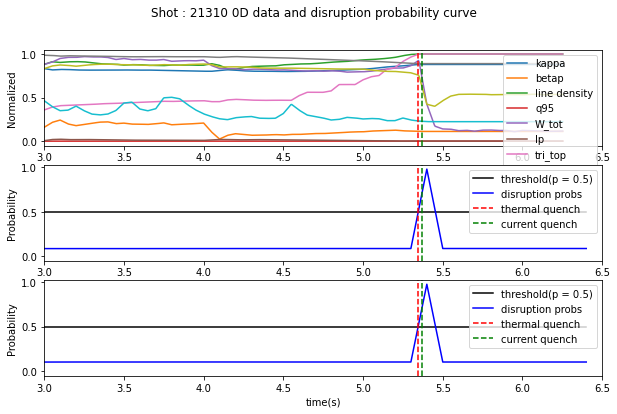

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,6), sharex = False)
fig.suptitle("Shot : {} 0D data and disruption probability curve".format(shot_num))
ax1.plot(t, kappa, label = "kappa")
ax1.plot(t, betap, label = 'betap')
ax1.plot(t, li, label = 'line density')
ax1.plot(t, q95, label = 'q95')
ax1.plot(t, W_tot, label = 'W_tot')
ax1.plot(t, ip, label = 'Ip')
ax1.plot(t, tritop, label = 'tri_top')
ax1.plot(t, tribot, label = 'tri_bot')
ax1.plot(t, ne, label = 'ne')
ax1.plot(t, te, label = 'Te')
ax1.set_xlim([3,6.5])
ax1.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", )
ax1.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed")
ax1.legend()
ax1.set_xlabel("time(s)")
ax1.set_ylabel("Normalized")

threshold_line = [0.5] * len(time_x)
ax2.plot(time_x, threshold_line, 'k', label = "threshold(p = 0.5)")
ax2.plot(time_x, prob_list, 'b-', label = "disruption probs")
ax2.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", label = "thermal quench")
ax2.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = "current quench")
ax2.legend()
ax2.set_xlim([3,6.5])
ax2.set_xlabel("time(s)")
ax2.set_ylabel("Probability")

threshold_line = [0.5] * len(time_x)
ax3.plot(time_x_dist3, threshold_line, 'k', label = "threshold(p = 0.5)")
ax3.plot(time_x_dist3, prob_list_dist3, 'b-', label = "disruption probs")
ax3.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", label = "thermal quench")
ax3.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = "current quench")
ax3.legend()
ax3.set_xlim([3,6.5])
ax3.set_xlabel("time(s)")
ax3.set_ylabel("Probability")

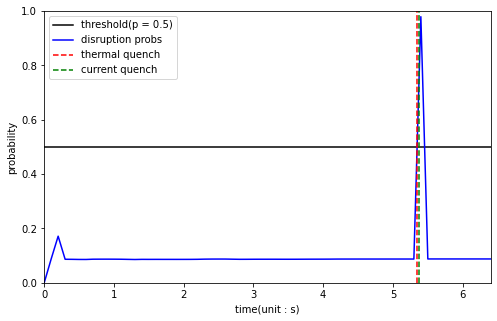

In [ ]:
threshold_line = [0.5] * len(time_x)

plt.figure(figsize = (8,5), facecolor = 'white')
plt.plot(time_x, threshold_line, 'k', label = "threshold(p = 0.5)")
plt.plot(time_x, prob_list, 'b-', label = "disruption probs")

plt.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", label = "thermal quench")
plt.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = "current quench")

plt.ylabel("probability")
plt.xlabel("time(unit : s)")
plt.ylim([0,1])
plt.xlim([0,max(time_x)])
plt.legend()

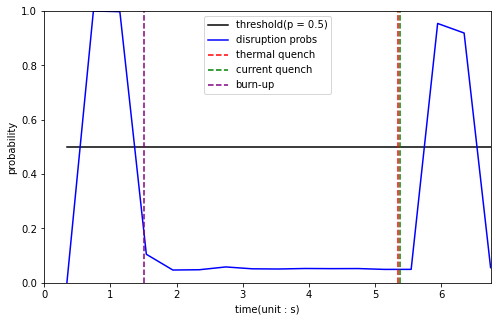

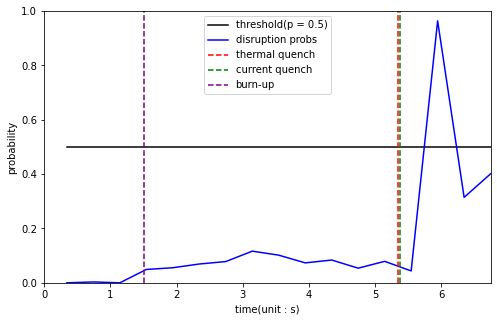

In [19]:
# For 0D data
from src.utils.utility import generate_prob_curve_from_0D
from src.models.ConvLSTM import ConvLSTM

ts_cols = [
    '\\q95', '\\ipmhd', '\\kappa', 
    '\\tritop', '\\tribot','\\betap','\\betan',
    '\\li', '\\WTOT_DLM03'
]

seq_len = 21
dist = 3
dt = 1 / 210 * 4
col_len = len(ts_cols)

model = ConvLSTM(
    seq_len = seq_len,
    col_dim = col_len,
)

# for dist 1
model.load_state_dict(torch.load("./weights/ts_conv_lstm_clip_21_dist_1_best.pt"))

time_x_dist1, prob_list_dist1 = generate_prob_curve_from_0D(
    model, 
    batch_size = 16, 
    device = device, 
    save_dir = "./results/disruption_probs_curve.png",
    ts_data = "./dataset/KSTAR_Disruption_ts_data_extend.csv",
    ts_cols = ts_cols,
    shot_list_dir = './dataset/KSTAR_Disruption_Shot_List_extend.csv',
    shot = 21310,
    seq_len = seq_len,
    dist = dist,
    dt = dt
)

model.load_state_dict(torch.load("./weights/ts_conv_lstm_clip_21_dist_3_best.pt"))

time_x_dist3, prob_list_dist3 = generate_prob_curve_from_0D(
    model, 
    batch_size = 16, 
    device = device, 
    save_dir = "./results/disruption_probs_curve.png",
    ts_data = "./dataset/KSTAR_Disruption_ts_data_extend.csv",
    ts_cols = ts_cols,
    shot_list_dir = './dataset/KSTAR_Disruption_Shot_List_extend.csv',
    shot = 21310,
    seq_len = seq_len,
    dist = dist,
    dt = dt
)

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
col = ['\\ipmhd','\\kappa','\\betap','\\betan', '\\li', '\\bcentr', '\\q95', '\\tritop', '\\tribot', '\\WTOT_DLM03', '\\ne_inter01', '\\TS_CORE10:CORE10_TE']
ts_data_0D[col] = scaler.fit_transform(ts_data_0D[col].values)

/tmp/ipykernel_2701623/530925373.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts_data_0D[col] = scaler.fit_transform(ts_data_0D[col].values)


Text(0, 0.5, 'Probability')

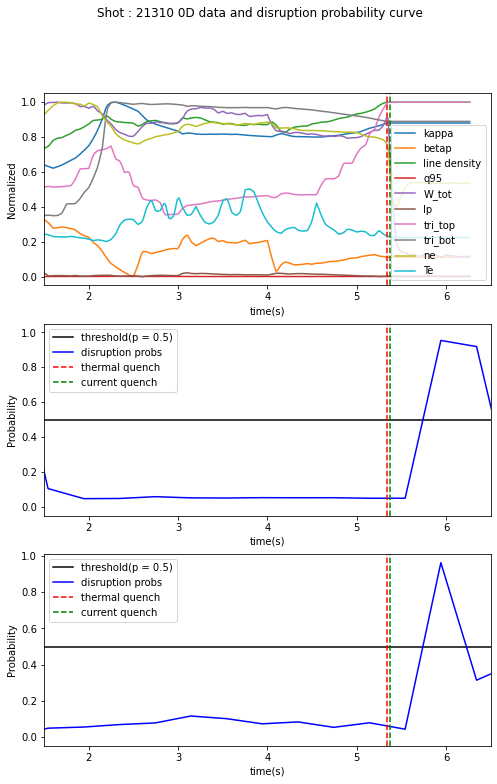

In [27]:
t = ts_data_0D.time
ip = ts_data_0D['\\ipmhd']
kappa = ts_data_0D['\\kappa']
betap = ts_data_0D['\\betap']
betan = ts_data_0D['\\betan']
li = ts_data_0D['\\li']
Bc = ts_data_0D['\\bcentr']
q95 = ts_data_0D['\\q95']
tritop = ts_data_0D['\\tritop']
tribot = ts_data_0D['\\tribot']
W_tot = ts_data_0D['\\WTOT_DLM03']
ne = ts_data_0D['\\ne_inter01']
te = ts_data_0D['\\TS_CORE10:CORE10_TE']

fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (8,12), sharex = False)
fig.suptitle("Shot : {} 0D data and disruption probability curve".format(shot_num))
ax1.plot(t, kappa, label = "kappa")
ax1.plot(t, betap, label = 'betap')
ax1.plot(t, li, label = 'line density')
ax1.plot(t, q95, label = 'q95')
ax1.plot(t, W_tot, label = 'W_tot')
ax1.plot(t, ip, label = 'Ip')
ax1.plot(t, tritop, label = 'tri_top')
ax1.plot(t, tribot, label = 'tri_bot')
ax1.plot(t, ne, label = 'ne')
ax1.plot(t, te, label = 'Te')
ax1.set_xlim([1.5,6.5])
ax1.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", )
ax1.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed")
ax1.legend()
ax1.set_xlabel("time(s)")
ax1.set_ylabel("Normalized")

threshold_line = [0.5] * len(time_x_dist1)
ax2.plot(time_x_dist1, threshold_line, 'k', label = "threshold(p = 0.5)")
ax2.plot(time_x_dist1, prob_list_dist1, 'b-', label = "disruption probs")
ax2.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", label = "thermal quench")
ax2.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = "current quench")
ax2.legend()
ax2.set_xlim([1.5,6.5])
ax2.set_xlabel("time(s)")
ax2.set_ylabel("Probability")

threshold_line = [0.5] * len(time_x_dist3)
ax3.plot(time_x_dist3, threshold_line, 'k', label = "threshold(p = 0.5)")
ax3.plot(time_x_dist3, prob_list_dist3, 'b-', label = "disruption probs")
ax3.axvline(x = t_TQend, ymin = 0, ymax = 1, color = "red", linestyle = "dashed", label = "thermal quench")
ax3.axvline(x = t_ipminf, ymin = 0, ymax = 1, color = "green", linestyle = "dashed", label = "current quench")
ax3.legend()
ax3.set_xlim([1.5,6.5])
ax3.set_xlabel("time(s)")
ax3.set_ylabel("Probability")